In [1]:
!pip install --upgrade geopandas


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install --upgrade shapely

!pip install --upgrade descartes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!apt install libspatialindex-dev
!pip install rtree
!pip install geopandas

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libspatialindex-dev is already the newest version (1.8.5-5).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Introduccion

Este notebook contiene los procesos que se han realizado para limpiar las bases de datos de contratos del sistema RENOVA de la SUPERINTENDENCIA DE VIGILANCIA Y SEGURIDAD PRIVADA DE COLOMBIA. 

Contiene las funciones e scripts para cargar los datasets en Jupyter o Colab, a partir de archivos en formato CSV. 

Esta es la primera etapa del trabajo con esstos datos. 


In [4]:
# First import the required libraries.
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns   
import geopandas as gpd

In [5]:
import pyproj
from shapely.geometry import Point, Polygon

In [6]:
# To load a file into colab:
import io
import os

In [7]:
# Ajustar No Maximo de Columnas para mostrar
# pd.get_option("display.max_columns")
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_columns', 20) # reset to default

In [8]:
# Ajustar el tamaño máximo de columna que se muestra
#pd.get_option('display.max_colwidth')
#pd.set_option('display.max_colwidth', -1) 
#pd.set_option('display.max_colwidth', 50)  # reset to default

In [9]:
# Ajustar el número máximo de filas para mostrar
#pd.get_option('display.max_rows')
pd.set_option('display.max_rows', None) # mostrar todas
#pd.set_option('display.max_rows', 60) # reset to default

In [10]:
#para poder ver los montos en valores con todas las cifras significativas en vez de notación científica
pd.set_option('display.float_format',  '{:,.2f}'.format)

# 1: **Data Loading**

## Load CSV into colab 
From Google Drive only (DO NOT RUN if in Jupyter):

In [11]:
# For Using Google Drive, (Only if executing notebook from Google colab):
from google.colab import drive
drive.mount('/content/drive')

# after that:
# <--- Refresh mounted Drive
# <--- Look for file and get the path link

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Find the file

In [12]:
# Get the current directory
print(os.getcwd())
# Check if the directory exists
print(os.path.exists('../'))

/content
True


In [13]:
ls

drive/  sample_data/


In [14]:
cd /content/drive/MyDrive/Observatorio SPVS/CU_Gasto/BD_Empresas

/content/drive/MyDrive/Observatorio SPVS/CU_Gasto/BD_Empresas


In [148]:
# Empresas RENOVA Consolidadas (Proveedoras de Servicios y de tecnologia)
PATH = '/content/drive/MyDrive/Observatorio SPVS/BD RENOVA - Empresas/ToPowerBI - Empresas_Inscritas_en_el_Registro (Consolidad).csv'
df_Empresas = pd.read_csv(PATH, encoding = 'utf-8', dtype='str', sep=',' )
df_Empresas.shape

(2522, 23)

In [149]:
df_Empresas.columns

Index(['Index', 'Repetido?', 'Repetido en la otra base', 'NIT', 'RAZÓN SOCIAL',
       'ACRÓNIMO', 'TIPO DE SERVICIO', 'TIPO DE TRÁMITE', 'TIPO OFICINA',
       'DIRECCIÓN', 'DEPARTAMENTO', 'CIUDAD', 'TELÉFONO',
       'CORREO ELECTRONICO - RUES', 'REPRESENTANTE LEGAL O ADMINISTRADOR',
       'ARRENDAMIENTO', 'COMERCIALIZACION', 'FABRICACION', 'IMPORTACION',
       'INSTALACION', 'Latitude', 'Longitude', 'Dirección Completa'],
      dtype='object')

In [172]:
df_Empresas = df_Empresas[df_Empresas['DEPARTAMENTO'] == 'BOGOTÁ D.C.']
df_Empresas.shape

(1445, 25)

In [173]:
# .str.replace('-', '')
df_Empresas.drop(df_Empresas.loc[df_Empresas['Latitude'] == '-'].index, inplace = True)
df_Empresas.drop(df_Empresas.loc[df_Empresas['Longitude'] == '-'].index, inplace = True)
df_Empresas.shape

(1445, 25)

In [174]:
df_Empresas['Latitude'] = df_Empresas['Latitude'].str.replace(',', '.')
df_Empresas['Longitude'] = df_Empresas['Longitude'].str.replace(',', '.')

AttributeError: ignored

In [175]:
df_Empresas['Latitude'] = df_Empresas['Latitude'].astype(float)
df_Empresas['Longitude'] = df_Empresas['Longitude'].astype(float)

# Georeference

In [176]:
# convert the coordinates to geometry data (Points) 
points_df = gpd.points_from_xy(df_Empresas.Longitude, df_Empresas.Latitude)
points_df = gpd.GeoDataFrame(df_Empresas, geometry=points_df)
points_df.geometry.head()

1    POINT (-74.08594 4.74313)
3    POINT (-74.09736 4.61591)
4    POINT (-74.11827 4.69322)
5    POINT (-74.14909 4.57557)
6    POINT (-74.09580 4.61260)
Name: geometry, dtype: geometry

In [177]:
df_Empresas.loc[1, 'Latitude']

4.7431263

In [178]:
# Cargar los polígonos de localidades desde un CSV
PATH = '/content/drive/MyDrive/Observatorio SPVS/BD RENOVA - Empresas/poligonos-localidades.csv'
df = pd.read_csv(PATH, sep = ';')
df.head()

,Nombre de la localidad,Acto administrativo de la localidad,Area de la localidad,Identificador unico de la localidad,Geometry,geo_point_2d
0,CIUDAD BOLIVAR,Acuerdo 14 de 1983,"130002593,080624",19,"{""coordinates"": [[[[-74.18135180099995, 4.5889...","4.482460265935783,-74.16195890440652"
1,SUBA,Acuerdo 8 de 1977,"100560477,718254",11,"{""coordinates"": [[[[-74.03449735499993, 4.8254...","4.763208121309928,-74.0758452755469"
2,RAFAEL URIBE URIBE,Acuerdo 117 de 2003,"13834084,806513",18,"{""coordinates"": [[[[-74.12803073399994, 4.5925...","4.566476900860273,-74.11336318293525"
3,KENNEDY,Acuerdo 8 de 1977,"38589733,814235",8,"{""coordinates"": [[[[-74.11829863999992, 4.6374...","4.6303473513560895,-74.15266762383382"
4,USME,Acuerdo 15 de 1993,"215066686,644374",5,"{""coordinates"": [[[[-74.0559679129999, 4.50832...","4.390025128368803,-74.14280649581936"


In [179]:
#from shapely import wkt
#df['Geometry'] = df['Geometry'].apply(wkt.loads)

#Localidades_df = gpd.GeoDataFrame(df, crs='epsg:4326')

In [180]:
#Localidades_df = gpd.read_file(PATH)
#Localidades_df.crs = 'epsg:4326'

In [181]:
#Localidades_df = gpd.GeoDataFrame(df)

In [182]:
# Cargar los poligonos de las localidades desde GeoJson
PATH =  '/content/drive/MyDrive/Observatorio SPVS/BD RENOVA - Empresas/poligonos-localidades.geojson'
Localidades_df = gpd.read_file(PATH)
Localidades_df['index'] = Localidades_df['Identificador unico de la localidad'].astype(int)
Localidades_df.set_index('index', drop = True, inplace=True)
Localidades_df = Localidades_df.sort_values(by = 'Identificador unico de la localidad')
Localidades_df.head()

,Nombre de la localidad,Acto administrativo de la localidad,Identificador unico de la localidad,Area de la localidad,geometry
index,,,,,
1,USAQUEN,Acuerdo 8 de 1977,01,"65315721,646621","MULTIPOLYGON (((-74.01089 4.66358, -74.01077 4..."
2,CHAPINERO,Acuerdo 8 de 1977,02,"38155857,205938","MULTIPOLYGON (((-74.01089 4.66358, -74.01090 4..."
3,SANTA FE,Acuerdo 117 de 2003,03,"45170645,863322","MULTIPOLYGON (((-73.99446 4.61425, -73.99453 4..."
4,SAN CRISTOBAL,Acuerdo 117 de 2003,04,"49098548,52917","MULTIPOLYGON (((-74.02900 4.55830, -74.02892 4..."
5,USME,Acuerdo 15 de 1993,05,"215066686,644374","MULTIPOLYGON (((-74.05597 4.50832, -74.05599 4..."


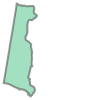

In [183]:
# Seleccionar un poligono de una localidad
#Localidad_1 = Localidades_df.loc[Localidades_df['Identificador unico de la localidad'] == 1, 'geometry'].values
Localidad_1 = Localidades_df.loc[1, 'geometry']
Localidad_1

In [184]:
# Centroide?
#C_1 = Localidades_df.loc[Localidades_df['Identificador unico de la localidad'] == 1, 'geo_point_2d']
#C_1 

In [185]:
# Seleccionar un punto
#punto_1 = (df_Empresas.loc[1, 'Latitude'], df_Empresas.loc[1, 'Longitude'])
#punto_1 = gpd.GeoDataFrame(df_Empresas, geometry= gpd.points_from_xy(df_Empresas.loc[1, 'Latitude'], df_Empresas.loc[1, 'Longitude']))
punto_1 = points_df.loc[1, 'geometry']
print(punto_1)

POINT (-74.0859421 4.7431263)


In [186]:
# Verificar que un punto está dentro de un polígono
print(Localidad_1.contains(punto_1))

False


In [187]:
for num_loc in Localidades_df.index.unique(): #Localidades_df['Identificador unico de la localidad'].unique()
    #Localidades_df.loc[Localidades_df['Identificador unico de la localidad'] == num_loc, 'Nombre de la localidad'].values
    print(num_loc, Localidades_df.loc[num_loc, 'Nombre de la localidad'])

1 USAQUEN
2 CHAPINERO
3 SANTA FE
4 SAN CRISTOBAL
5 USME
6 TUNJUELITO
7 BOSA
8 KENNEDY
9 FONTIBON
10 ENGATIVA
11 SUBA
12 BARRIOS UNIDOS
13 TEUSAQUILLO
14 LOS MARTIRES
15 ANTONIO NARIÑO
16 PUENTE ARANDA
17 CANDELARIA
18 RAFAEL URIBE URIBE
19 CIUDAD BOLIVAR
20 SUMAPAZ


In [188]:
# Verificar que muchos puntos estan dentro de un polígono:
#serie = gpd.sjoin(points_df, Localidades_df,  op='within') #  op='contains'
serie = points_df['geometry'].within(Localidad_1)
serie.head()

1    False
3    False
4    False
5    False
6    False
dtype: bool

In [189]:
points_df['Localidad'] = 'Fuera del D.C.'

for num_loc in Localidades_df.index.unique():
    localidad = Localidades_df.loc[num_loc, 'geometry']
    nombre_localidad = Localidades_df.loc[num_loc, 'Nombre de la localidad']

    points_df.loc[points_df['geometry'].within(localidad), 'Localidad'] = nombre_localidad


points_df['Localidad'].value_counts()

BARRIOS UNIDOS        267
CHAPINERO             197
SUBA                  162
ENGATIVA              159
USAQUEN               147
TEUSAQUILLO           125
FONTIBON               78
PUENTE ARANDA          75
KENNEDY                59
SANTA FE               54
LOS MARTIRES           34
SAN CRISTOBAL          23
CANDELARIA             15
RAFAEL URIBE URIBE     14
ANTONIO NARIÑO         12
TUNJUELITO              8
No coincide             6
CIUDAD BOLIVAR          5
BOSA                    3
USME                    2
Name: Localidad, dtype: int64

In [197]:
points_df['Localidad'].value_counts().to_frame()

,Localidad
BARRIOS UNIDOS,267
CHAPINERO,197
SUBA,162
ENGATIVA,159
USAQUEN,147
TEUSAQUILLO,125
FONTIBON,78
PUENTE ARANDA,75
KENNEDY,59
SANTA FE,54


In [190]:
points_df['Localidad'].unique()

array(['SUBA', 'PUENTE ARANDA', 'ENGATIVA', 'CIUDAD BOLIVAR',
       'CANDELARIA', 'CHAPINERO', 'LOS MARTIRES', 'USAQUEN',
       'No coincide', 'SANTA FE', 'TEUSAQUILLO', 'KENNEDY', 'FONTIBON',
       'RAFAEL URIBE URIBE', 'SAN CRISTOBAL', 'BARRIOS UNIDOS', 'BOSA',
       'ANTONIO NARIÑO', 'TUNJUELITO', 'USME'], dtype=object)

In [191]:
points_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1445 entries, 1 to 2521
Data columns (total 25 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   Index                                1445 non-null   object  
 1   Repetido?                            1444 non-null   object  
 2   Repetido en la otra base             6 non-null      object  
 3   NIT                                  1445 non-null   object  
 4   RAZÓN SOCIAL                         1445 non-null   object  
 5   ACRÓNIMO                             1441 non-null   object  
 6   TIPO DE SERVICIO                     1445 non-null   object  
 7   TIPO DE TRÁMITE                      763 non-null    object  
 8   TIPO OFICINA                         1445 non-null   object  
 9   DIRECCIÓN                            1445 non-null   object  
 10  DEPARTAMENTO                         1445 non-null   object  
 11  CIUDAD   

In [192]:
ls

'Empresas_localidad (1).gsheet'
 Empresas_localidad.csv
 Empresas_localidad.gsheet
 empresas_que_contratan_con_estado.csv
 empresas_que_contratan_en_SECOP_2.csv
 empresas_que_contratan_en_SECOP.csv
 lista_empresas_en_SECOP.csv
 NITs_IDs_BD_RENOVA-Contratos_cliente_gobierno.csv


In [193]:
#points_df.to_csv('Empresas_localidad.csv')

In [194]:
points_df.columns

Index(['Index', 'Repetido?', 'Repetido en la otra base', 'NIT', 'RAZÓN SOCIAL',
       'ACRÓNIMO', 'TIPO DE SERVICIO', 'TIPO DE TRÁMITE', 'TIPO OFICINA',
       'DIRECCIÓN', 'DEPARTAMENTO', 'CIUDAD', 'TELÉFONO',
       'CORREO ELECTRONICO - RUES', 'REPRESENTANTE LEGAL O ADMINISTRADOR',
       'ARRENDAMIENTO', 'COMERCIALIZACION', 'FABRICACION', 'IMPORTACION',
       'INSTALACION', 'Latitude', 'Longitude', 'Dirección Completa',
       'geometry', 'Localidad'],
      dtype='object')

In [195]:
points_df.groupby(['Localidad'])['TIPO DE SERVICIO'].value_counts()

Localidad           TIPO DE SERVICIO                                                             
ANTONIO NARIÑO      INSCRITA EN EL REGISTRO                                                            6
                    EMPRESA DE VIGILANCIA  Y SEGURIDAD PRIVADA                                         3
                    DEPARTAMENTO DE SEGURIDAD                                                          1
                    EMPRESA ASESORA, CONSULTORA,  INVESTIGADORA EN VIGILANCIA Y SEGURIDAD PRIVADA      1
                    EMPRESA BLINDADORA DE VEHICULOS                                                    1
BARRIOS UNIDOS      EMPRESA DE VIGILANCIA  Y SEGURIDAD PRIVADA                                       133
                    INSCRITA EN EL REGISTRO                                                           85
                    DEPARTAMENTO DE SEGURIDAD                                                         11
                    ESCUELAS DE CAPACITACIÓN Y ENTRENAMIENTO  

In [196]:
points_df.groupby(['Localidad'])['TIPO DE SERVICIO'].value_counts().to_frame()

TIPO DE SERVICIO
Localidad          TIPO DE SERVICIO                                                    
ANTONIO NARIÑO     INSCRITA EN EL REGISTRO                                            6
                   EMPRESA DE VIGILANCIA  Y SEGURIDAD PRIVADA                         3
                   DEPARTAMENTO DE SEGURIDAD                                          1
                   EMPRESA ASESORA, CONSULTORA,  INVESTIGADORA EN ...                 1
                   EMPRESA BLINDADORA DE VEHICULOS                                    1
BARRIOS UNIDOS     EMPRESA DE VIGILANCIA  Y SEGURIDAD PRIVADA                       133
                   INSCRITA EN EL REGISTRO                                           85
                   DEPARTAMENTO DE SEGURIDAD                                         11
                   ESCUELAS DE CAPACITACIÓN Y ENTRENAMIENTO                          10
                   EMPRESA ARRENDADORA DE VEHICULOS BLINDADOS                         8
                   EMPRESA BLINDADORA DE VEHICULOS                                    8
                   COOPERATIVA DE VIGILANCIA Y SEGURIDAD PRIVADA                      6
                   EMPRESA ASESORA, CONSULTORA,  INVESTIGADORA EN ...                 3
                   TRANSPORTADORA DE VALORES                                          3
BOSA               DEPARTAMENTO DE SEGURIDAD                                          2
                   INSCRITA EN EL REGISTRO                                            1
CANDELARIA         DEPARTAMENTO DE SEGURIDAD                                          7
                   INSCRITA EN EL REGISTRO                                            5
                   EMPRESA DE VIGILANCIA  Y SEGURIDAD PRIVADA                         2
                   DEPARTAMENTO DE CAPACITACIÓN                                       1
CHAPINERO          INSCRITA EN EL REGISTRO                                          126
                   DEPARTAMENTO DE SEGURIDAD                                         47
                   EMPRESA DE VIGILANCIA  Y SEGURIDAD PRIVADA                        13
                   EMPRESA ASESORA, CONSULTORA,  INVESTIGADORA EN ...                 8
                   DEPARTAMENTO DE CAPACITACIÓN                                       2
                   COOPERATIVA DE VIGILANCIA Y SEGURIDAD PRIVADA                      1
CIUDAD BOLIVAR     DEPARTAMENTO DE SEGURIDAD                                          3
                   EMPRESA DE VIGILANCIA  Y SEGURIDAD PRIVADA                         2
ENGATIVA           EMPRESA DE VIGILANCIA  Y SEGURIDAD PRIVADA                        73
                   INSCRITA EN EL REGISTRO                                           57
                   DEPARTAMENTO DE SEGURIDAD                                         13
                   ESCUELAS DE CAPACITACIÓN Y ENTRENAMIENTO                           7
                   COOPERATIVA DE VIGILANCIA Y SEGURIDAD PRIVADA                      3
                   DEPARTAMENTO DE CAPACITACIÓN                                       2
                   EMPRESA BLINDADORA DE VEHICULOS                                    2
                   EMPRESA ARRENDADORA DE VEHICULOS BLINDADOS                         1
                   EMPRESA ASESORA, CONSULTORA,  INVESTIGADORA EN ...                 1
FONTIBON           INSCRITA EN EL REGISTRO                                           31
                   EMPRESA DE VIGILANCIA  Y SEGURIDAD PRIVADA                        21
                   DEPARTAMENTO DE SEGURIDAD                                         19
                   DEPARTAMENTO DE CAPACITACIÓN                                       2
                   EMPRESA BLINDADORA DE VEHICULOS                                    2
                   TRANSPORTADORA DE VALORES                                          2
                   ESCUELAS DE CAPACITACIÓN Y ENTRENAMIENTO                           1
KENNEDY            EMPR

In [ ]:
'ARRENDAMIENTO', 'COMERCIALIZACION', 'FABRICACION', 'IMPORTACION',
       'INSTALACION'

In [209]:
Registro =  'INSTALACION'

points_df[Registro] = points_df[Registro].str.upper()
points_df.groupby(['Localidad'])[Registro].value_counts().to_frame()

,,INSTALACION
Localidad,INSTALACION,
ANTONIO NARIÑO,INSTALACION,3
BARRIOS UNIDOS,INSTALACION,61
CANDELARIA,INSTALACION,2
CHAPINERO,INSTALACION,80
ENGATIVA,INSTALACION,39
FONTIBON,INSTALACION,21
KENNEDY,INSTALACION,15
LOS MARTIRES,INSTALACION,10
No coincide,INSTALACION,3
